# 3D Image Segmentation
Image segmentation in 3D is challenging for several reasons: In many microscopy imaging techniques, image quality varies in space: For example intensity and/or contrast degrades the deeper you image inside a sample. Furthermore, touching nuclei are hard to differentiate in an automated way. Last but not least, anisotropy is difficult to handle depending on the applied algorithms and respective given parameters. Some algorithms, like the [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) approach demonstrated here, only work for isotropic data.

In [1]:
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import numpy as np

import napari
from napari.utils import nbscreenshot

Check if you have a powerful graphics card and select it with the command below.
Otherwise, you may need to run the `Segmentation_3D_only_skimage` notebook.

In [2]:
# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

<GeForce GTX 1650 Ti with Max-Q Design on Platform: NVIDIA CUDA (1 refs)>

To demonstrate the workflow, we're using cropped and resampled image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

In [4]:
input_image = imread("./data/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

We can check that we have loaded a 3D image by printing its shape:

In [5]:
input_image.shape

(86, 396, 393)

For visualisation purposes we show intensity projections along X, Y and Z.

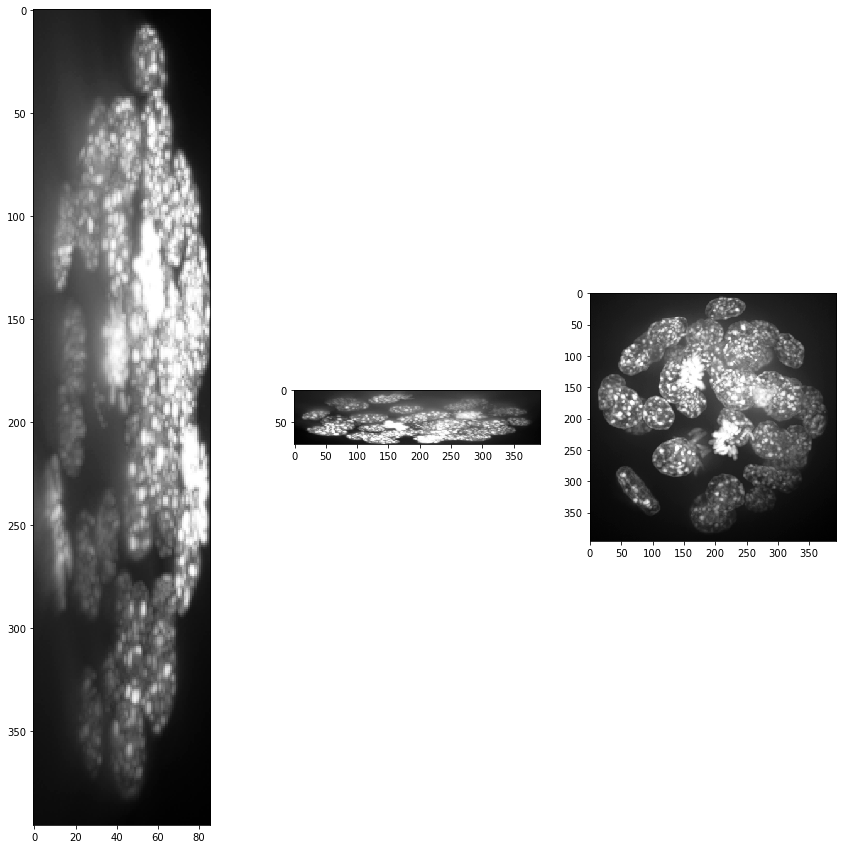

In [6]:
projection_x = cle.maximum_x_projection(input_image)
projection_y = cle.maximum_y_projection(input_image)
projection_z = cle.maximum_z_projection(input_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(projection_x, plot=axs[0])
cle.imshow(projection_y, plot=axs[1])
cle.imshow(projection_z, plot=axs[2])
plt.show()

Obviously, voxel size is not isotropic. Thus, we scale the image with the voxel size used as scaling factor to get an image stack with isotropic voxels.

In [7]:
resampled = cle.scale(input_image,
                      factor_x=voxel_size_x, 
                      factor_y=voxel_size_y, 
                      factor_z=voxel_size_z, 
                      auto_size=True)
resampled.shape

(86, 79, 79)

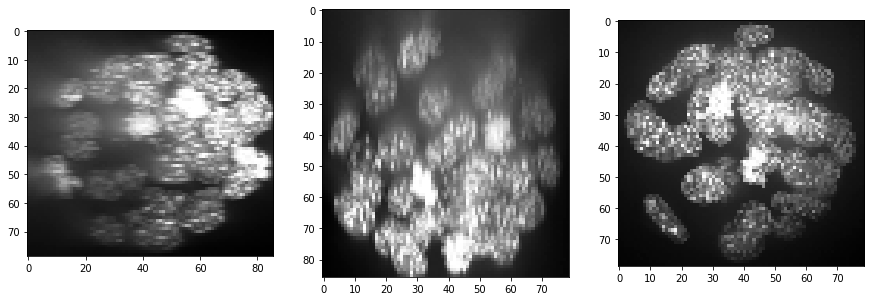

In [8]:
projection_x = cle.maximum_x_projection(resampled)
projection_y = cle.maximum_y_projection(resampled)
projection_z = cle.maximum_z_projection(resampled)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(projection_x, plot=axs[0])
cle.imshow(projection_y, plot=axs[1])
cle.imshow(projection_z, plot=axs[2])
plt.show()

## Background correction
background intensity appears to increase, potentially a result if more scattering deep in the sample. We can compensate for that by using a background subtraction technique:

In [9]:
background_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)

## Segmentation
As mentioned before, we perform the [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) approach here to segment nuclei in 3D.

In [10]:
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=3, outline_sigma=1)

## Visualization in 3D
For actual visualization in 3D you can also use [napari](https://napari.org/).

In [10]:
# start napari
viewer = napari.Viewer()

C:\Users\mazo260d\Miniconda3\envs\bookenv\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [11]:
# show images
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(background_subtracted))
viewer.add_labels(cle.pull(segmented))

<Labels layer 'Labels' at 0x28307798dc0>

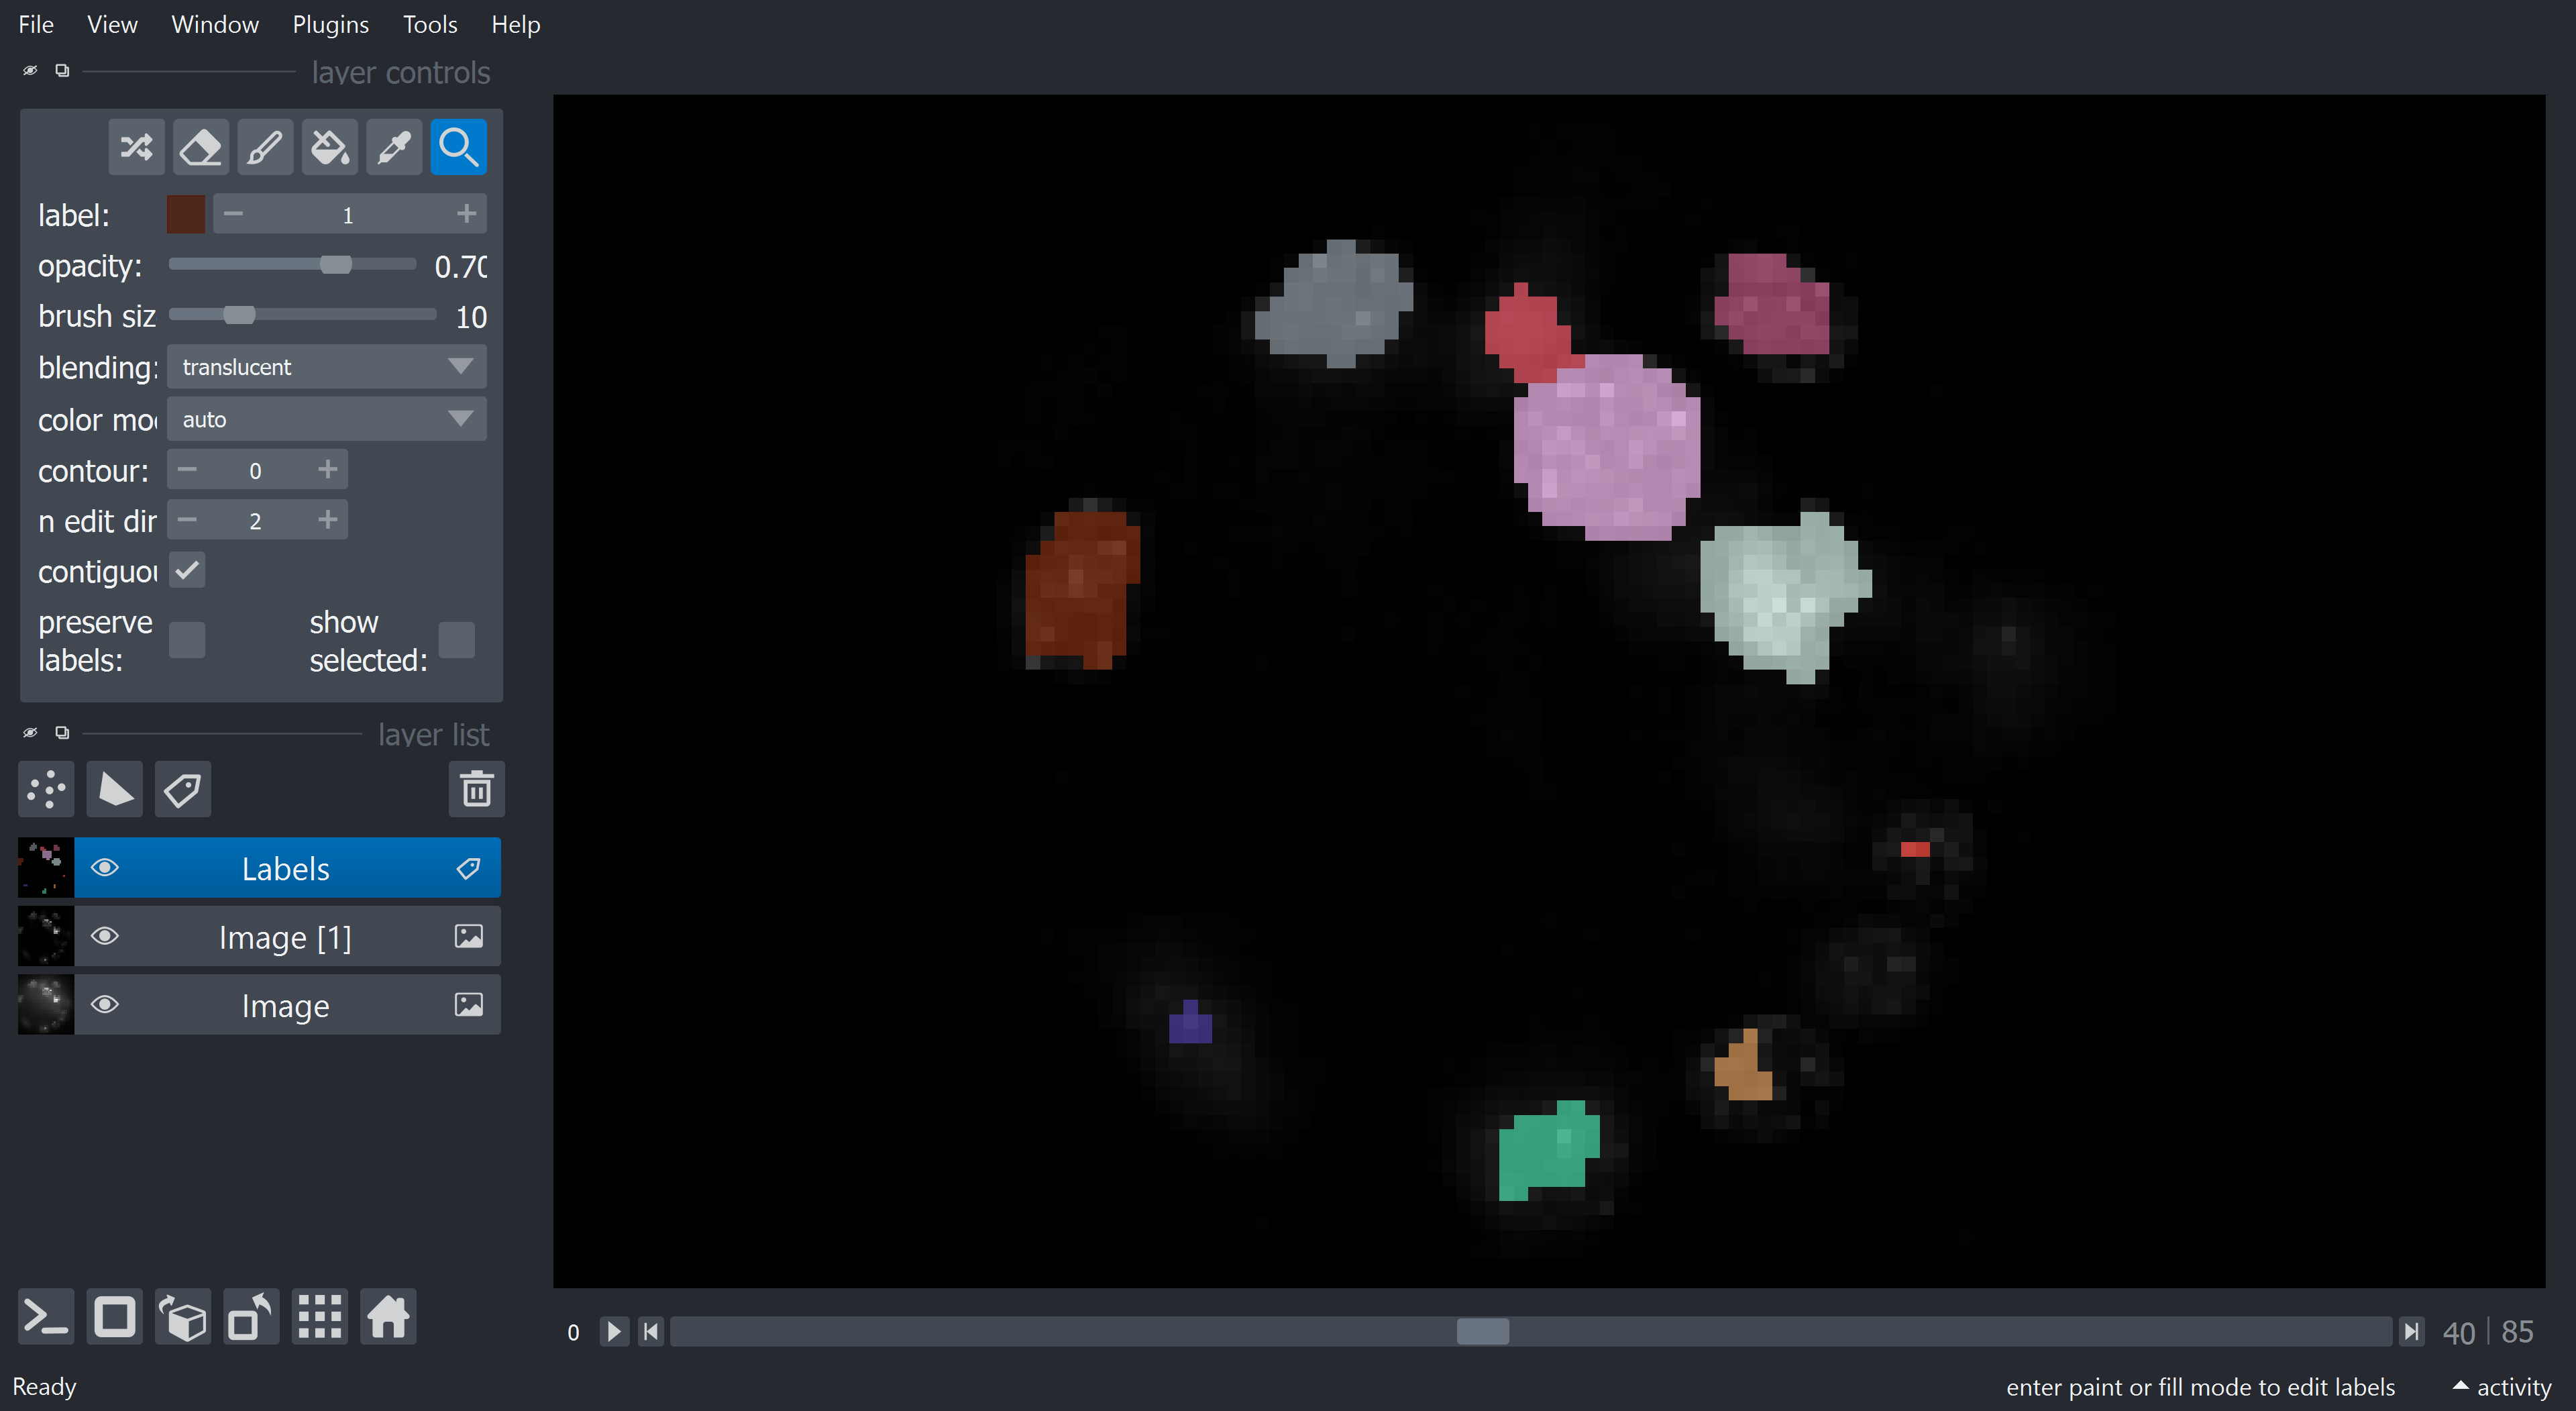

In [12]:
viewer.dims.current_step = (40, 0, 0)
nbscreenshot(viewer)

We can switch to a 3D view by clicking on the 3D button in the bottom left corner.

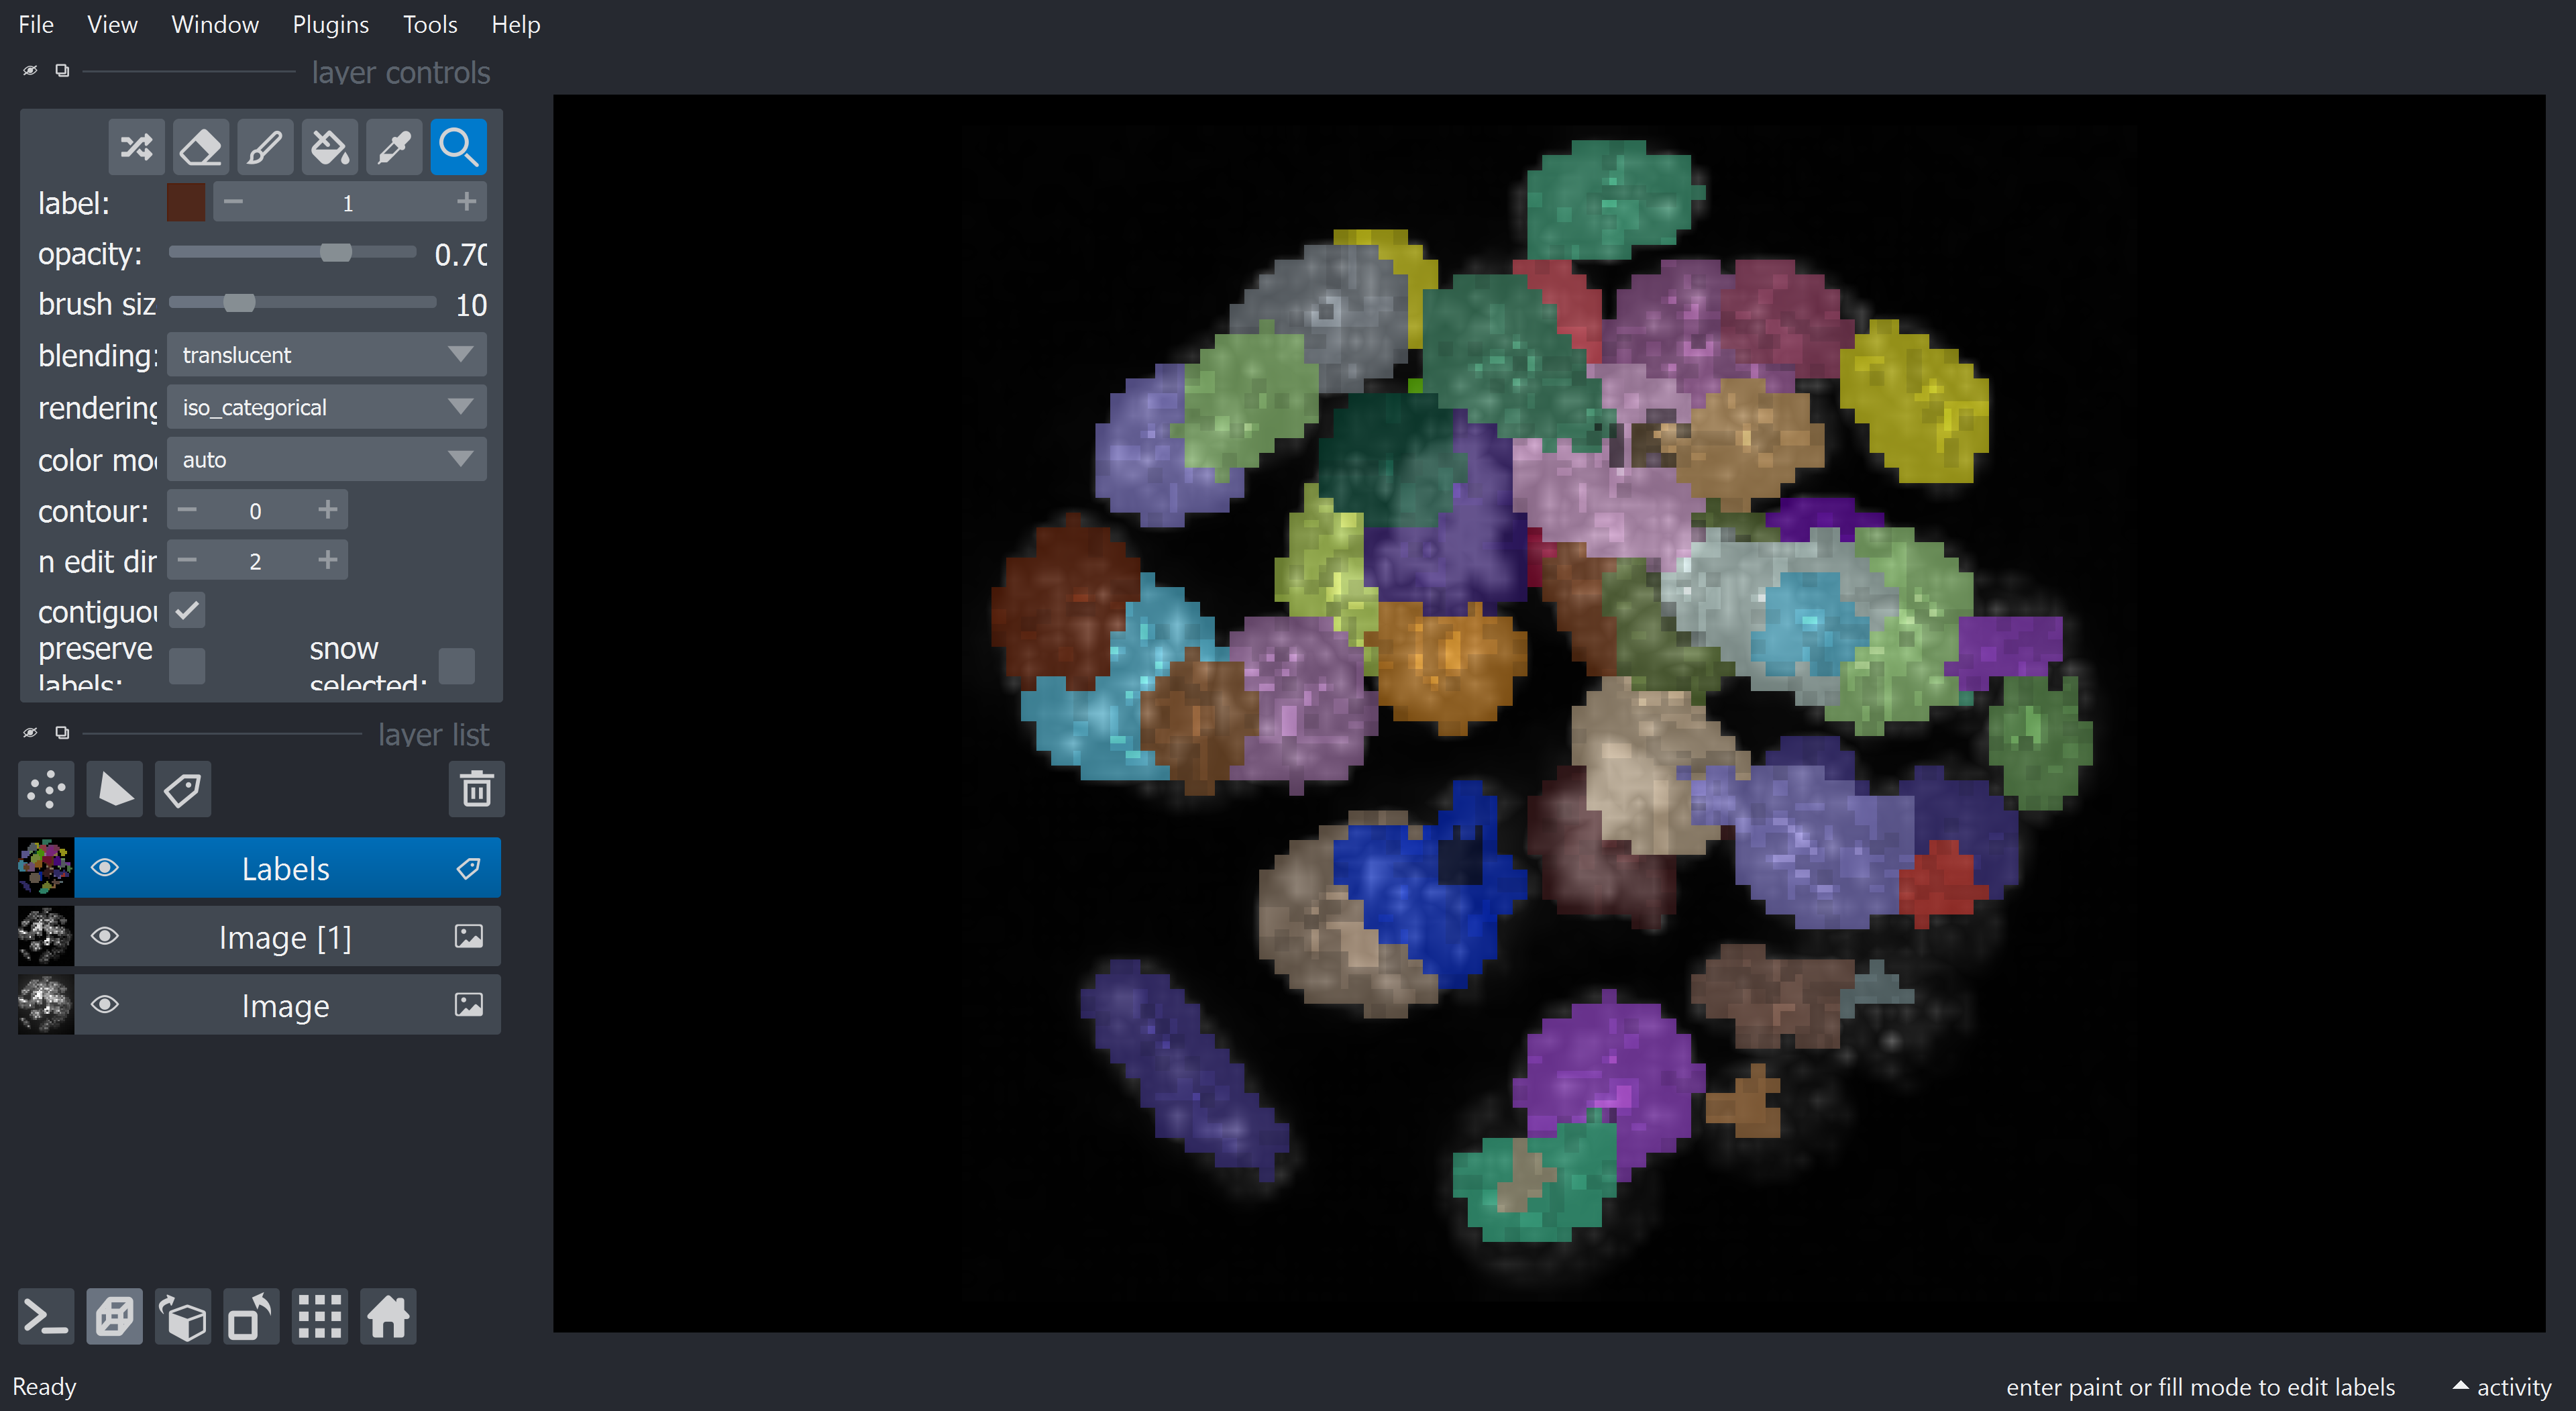

In [13]:
viewer.dims.ndisplay = 3
nbscreenshot(viewer)

# Saving labels

We can save the labels as an image with imsave from skimage.

In [14]:
imsave("./data/BMP4blastocystC3-cropped_resampled_8bit_labels.tif", segmented)

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_19108\1151524937.py:1: UserWarning: ./data/BMP4blastocystC3-cropped_resampled_8bit_labels.tif is a low contrast image
  imsave("./data/BMP4blastocystC3-cropped_resampled_8bit_labels.tif", segmented)


Note: the saved labeled image has a different shape from the original image because the image was made isotropic.
If one wants the labeled image to match the original image shape, the labeled image has to be scaled back to the original format.

In [15]:
segmented.shape

(86, 79, 79)

In [16]:
rescaled = np.empty_like(input_image)
rescaled = cle.scale(segmented, factor_x = 1/0.202, factor_y = 1/0.202, factor_z = 1, auto_size=True)
rescaled.shape

(86, 391, 391)